In [1]:
# Plot HPLC data for the Chx allophototropha paper - supplementary BChla data
# Jackson M. Tsuji, ILTS, Hokkaido University, 2023

In [2]:
import pandas as pd
from plotnine import *
from scipy.signal import find_peaks
from collections import namedtuple
from numpy import linspace
from scipy import stats

In [3]:
def load_hplc_pda_data(pda_filepath, pre_processed=False):

    if pre_processed is False:
        hplc_profile_data = pd.read_csv(pda_filepath, sep='\t', skiprows=list(range(0,9))+list(range(10,19)),
                                        encoding_errors='replace')\
          .rename(columns={'WAVE.TABLE':'Retention time (min)'})

    elif pre_processed is True:
        hplc_profile_data = pd.read_csv(pda_filepath, sep='\t')

    else:
        raise ValueError(f'pre_processed must be True or False, but you provided {pre_processed}')
    
    return(hplc_profile_data)

def tabulate_peaks(data_table, signal_col_name, ref_col_name, prominence):
    peak_pos, _ = find_peaks(data_table[signal_col_name].to_numpy(), prominence=prominence)
    peak_ref_values = data_table[ref_col_name][peak_pos]
    peak_heights = data_table[data_table[ref_col_name].isin(peak_ref_values)][signal_col_name]

    peak_table = pd.DataFrame({ref_col_name:peak_ref_values, signal_col_name:peak_heights})
    return(peak_table)

def tabulate_spectra(hplc_profile_data, retention_times, round_digits=None):
    spectra_data = hplc_profile_data[hplc_profile_data['Retention time (min)'].isin(retention_times)]\
      .set_index('Retention time (min)')\
      .transpose()\
      .reset_index()\
      .rename(columns={'index':'Wavelength (nm)'})\
      .melt(id_vars='Wavelength (nm)', value_name='Absorbance (A.U.)')
    
    spectra_data = spectra_data.astype({'Wavelength (nm)':'int64', 'Retention time (min)':'float64'})
    
    if round_digits is not None:
        spectra_data['Retention time (min)'] = spectra_data['Retention time (min)'].round(round_digits)
    
    return(spectra_data)

In [4]:
def get_spectrum_of_peak_in_range(hplc_data_processed, time_min_max: tuple):

    bchla_peak_time = hplc_data_processed.tables.peaks['Retention time (min)']\
      [hplc_data_processed.tables.peaks['Retention time (min)'].between(time_min_max[0],time_min_max[1])]
    
    if len(bchla_peak_time) == 0:
        
        print('WARNING: no captured peaks')
        spectrum = None
    
    elif len(bchla_peak_time) > 1:
        
        print('ERROR: more than one captured peak')
        exit
        
    else:
        
        print('Peak found at ' + str(round(bchla_peak_time.to_list()[0], 2)) + ' min.')

        spectrum = tabulate_spectra(hplc_data_processed.tables.profile, bchla_peak_time, round_digits=None)
    
    return spectrum

In [5]:
def process_hplc_data(pda_filepath, wavelength, provinence_profile=2000, provinence_spectrum=90000, pre_loaded_pda=False):
    wavelength = str(wavelength)
    
    # Load data
    if pre_loaded_pda is False:
        hplc_profile_data = load_hplc_pda_data(pda_filepath)
    else:
        hplc_profile_data = pda_filepath # assumes a pandas df of the correct format was passed in

    # Get peaks
    peaks = tabulate_peaks(hplc_profile_data, wavelength, 'Retention time (min)', provinence_profile)
    print('Identified ' + str(peaks.shape[0]) + ' peaks in HPLC profile at ' + wavelength + ' nm')
    
    profile_plot = (ggplot(hplc_profile_data, aes(x='Retention time (min)', y=wavelength))
              + geom_vline(xintercept=peaks['Retention time (min)'], linetype='dashed', colour='grey')
              + geom_path(size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank())
              + ylab('Absorbance at ' + wavelength + ' nm (A.U.)')
              )

    # Get associated spectra with peaks
    spectra = tabulate_spectra(hplc_profile_data, peaks['Retention time (min)'], round_digits=2)
    
    spectra_plot = (ggplot(spectra, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                   + geom_path()
                   + facet_grid('Retention time (min) ~ .', scales='free_y')
                   + theme_bw()
                   + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank())
                  )
    
    spectra_pre_plot = spectra.copy(deep=True)
    spectra_pre_plot['Retention time (min)'] = spectra_pre_plot['Retention time (min)'].astype('str')
    spectra_pre_plot['Retention time (min)'] = pd.Categorical(spectra_pre_plot['Retention time (min)'], 
                                                              categories=spectra_pre_plot['Retention time (min)'].unique(), ordered=True)

    spectra_overlay_plot = (ggplot(spectra_pre_plot, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                           + geom_path(aes(group='Retention time (min)', colour='Retention time (min)'), alpha=0.8, size=1)
                           + theme_bw()
                           + theme(text=element_text(colour='black', family='Arial'),
                              panel_grid=element_blank())
                          )
    
    # Get the spectrum associated with just the largest peak
    max_peak_rt = peaks[peaks[wavelength] == peaks[wavelength].max()]['Retention time (min)']
    spectra_max = tabulate_spectra(hplc_profile_data, max_peak_rt, round_digits=2)

    # Get absorbance peaks
    spectra_max_peaks = tabulate_peaks(spectra_max, 'Absorbance (A.U.)', 'Wavelength (nm)', provinence_spectrum)
    print('Identified ' + str(spectra_max_peaks.shape[0]) + ' peaks in largest profile absorbance spectrum at ' + str(round(list(max_peak_rt)[0],2)) + ' min')

    spectrum_max_plot = (ggplot(spectra_max, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                         + geom_vline(xintercept=spectra_max_peaks['Wavelength (nm)'], linetype='dashed', colour='grey')
                         + geom_path(size=0.8)
                         + theme_bw()
                         + theme(text=element_text(colour='black', family='Arial'),
                            panel_grid=element_blank())
                        )

    hplc_output = namedtuple('hplc_output', ['tables','figures'])
    table_output = namedtuple('table_output', ['profile','peaks','spectra','spectrum_max','spectrum_max_peaks'])
    figure_output = namedtuple('figure_output', ['profile', 'spectra_align', 'spectra_overlay', 'spectrum_max'])
    
    return(hplc_output(table_output(hplc_profile_data,peaks,spectra,spectra_max,spectra_max_peaks), 
                       figure_output(profile_plot, spectra_plot, spectra_overlay_plot, spectrum_max_plot)))

In [6]:
# Load
# Data from run 1
caur_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Cfx-aurantiacus-HPLC-run1.tsv.gz', pre_processed=True)
cferro_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Chl-ferrooxidans-HPLC-run1.tsv.gz', pre_processed=True)
chx_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Ca-Chx-allophototropha-L227-S17-HPLC-run1.tsv.gz', pre_processed=True)

# Data from run 2
rcaps_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Rba-capsulatus-HPLC-run2.tsv.gz', pre_processed=True)
caur2_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Cfx-aurantiacus-HPLC-run2.tsv.gz', pre_processed=True)

caur_raw.head()

,Retention time (min),350,351,352,353,354,355,356,357,358,...,791,792,793,794,795,796,797,798,799,800
0,0.000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.032,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
caur_processed = process_hplc_data(caur_raw, wavelength=770, provinence_profile=2000, 
                                   provinence_spectrum=90000, pre_loaded_pda=True)
#caur_processed.figures

Identified 9 peaks in HPLC profile at 770 nm
Identified 2 peaks in largest profile absorbance spectrum at 35.76 min


In [8]:
cferro_processed = process_hplc_data(cferro_raw, wavelength=770, provinence_profile=2000, 
                                     provinence_spectrum=90000, pre_loaded_pda=True)
#cferro_processed.figures

Identified 11 peaks in HPLC profile at 770 nm
Identified 0 peaks in largest profile absorbance spectrum at 4.58 min


In [9]:
chx_processed = process_hplc_data(chx_raw, wavelength=770, provinence_profile=500, 
                                  provinence_spectrum=1000, pre_loaded_pda=True)
#chx_processed.figures

Identified 15 peaks in HPLC profile at 770 nm
Identified 12 peaks in largest profile absorbance spectrum at 4.59 min


In [10]:
rcaps_processed = process_hplc_data(rcaps_raw, wavelength=770, provinence_profile=2000, 
                                    provinence_spectrum=90000, pre_loaded_pda=True)
#rcaps_processed.figures

Identified 3 peaks in HPLC profile at 770 nm
Identified 1 peaks in largest profile absorbance spectrum at 37.94 min


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


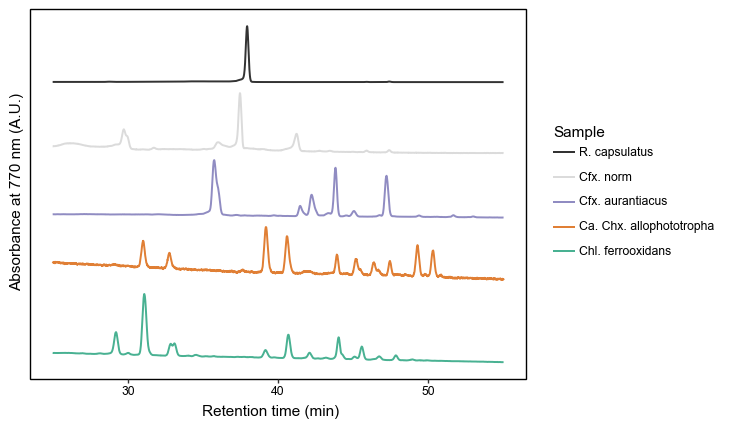

<ggplot: (385345528)>

In [11]:
# Make a non-normalized plot of all data at 770 nm
hplc_profiles_merged = caur_raw[['Retention time (min)', '770']].rename(columns={'770': 'Cfx. aurantiacus'})\
  .merge(cferro_raw[['Retention time (min)', '770']].rename(columns={'770': 'Chl. ferrooxidans'}), on='Retention time (min)', how='inner')\
  .merge(chx_raw[['Retention time (min)', '770']].rename(columns={'770': 'Ca. Chx. allophototropha'}), on='Retention time (min)', how='inner')\
  .merge(rcaps_raw[['Retention time (min)', '770']].rename(columns={'770': 'R. capsulatus'}), on='Retention time (min)', how='inner')\
  .merge(caur2_raw[['Retention time (min)', '770']].rename(columns={'770': 'Cfx. norm'}), on='Retention time (min)', how='inner')
hplc_profiles_merged = hplc_profiles_merged[(hplc_profiles_merged['Retention time (min)'] > 25) & (hplc_profiles_merged['Retention time (min)'] < 55)]

# Normalize based on max peak height
max1 = hplc_profiles_merged['Cfx. aurantiacus'].max()
max2 = hplc_profiles_merged['Chl. ferrooxidans'].max()
max3 = hplc_profiles_merged['Ca. Chx. allophototropha'].max()
max4 = hplc_profiles_merged['R. capsulatus'].max()
max5 = hplc_profiles_merged['Cfx. norm'].max()
hplc_profiles_merged['Cfx. aurantiacus'] = hplc_profiles_merged['Cfx. aurantiacus'] * max4 / max1
hplc_profiles_merged['Chl. ferrooxidans'] = hplc_profiles_merged['Chl. ferrooxidans'] * max4 / max2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] * max4 / max3
hplc_profiles_merged['Cfx. norm'] = hplc_profiles_merged['Cfx. norm'] * max4 / max5

# Offset
offset = max4 * 1.2
hplc_profiles_merged['R. capsulatus'] = hplc_profiles_merged['R. capsulatus'] + offset * 4
hplc_profiles_merged['Cfx. norm'] = hplc_profiles_merged['Cfx. norm'] + offset * 3
hplc_profiles_merged['Cfx. aurantiacus'] = hplc_profiles_merged['Cfx. aurantiacus'] + offset * 2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] + offset

hplc_profiles_merged = hplc_profiles_merged.melt(id_vars='Retention time (min)', var_name='Sample', value_name='Absorbance (A.U.)')

hplc_profiles_merged['Sample'] = pd.Categorical(hplc_profiles_merged['Sample'], 
                                                categories=['R. capsulatus', 'Cfx. norm', 'Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans'], ordered=True)

profile_plot = (ggplot(hplc_profiles_merged, aes(x='Retention time (min)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#000000', '#d2d2d2', '#7570b3', '#d95f02', '#1b9e77'])
              + ylab('Absorbance at 770 nm (A.U.)')
              )

profile_plot

In [12]:
# Now calculate the normalization based on the two Cfx. aurantiacus samples at 667 nm (for bchl c)
caur_processed_bchlc = process_hplc_data(caur_raw, wavelength=667, provinence_profile=2000, 
                                         provinence_spectrum=90000, pre_loaded_pda=True)
caur2_processed_bchlc = process_hplc_data(caur2_raw, wavelength=667, provinence_profile=1000, 
                                          provinence_spectrum=50000, pre_loaded_pda=True)

# Find the top 3 highest peaks
caur_norm_peaks = caur_processed_bchlc.tables.peaks[(caur_processed_bchlc.tables.peaks['Retention time (min)'] > 25) & 
                                                    (caur_processed_bchlc.tables.peaks['Retention time (min)'] < 55)]
caur_norm_peaks = caur_norm_peaks.sort_values(by='667', ascending=False).head(3)\
  .sort_values(by='Retention time (min)', ascending=True, ignore_index=True)\
  .reset_index().rename(columns={'index':'peak_num'})
caur_norm_peaks['Run'] = 'Run 1'


caur2_norm_peaks = caur2_processed_bchlc.tables.peaks[(caur2_processed_bchlc.tables.peaks['Retention time (min)'] > 25) & 
                                                      (caur2_processed_bchlc.tables.peaks['Retention time (min)'] < 55)]
caur2_norm_peaks = caur2_norm_peaks.sort_values(by='667', ascending=False).head(3)\
  .sort_values(by='Retention time (min)', ascending=True, ignore_index=True)\
  .reset_index().rename(columns={'index':'peak_num'})
caur2_norm_peaks['Run'] = 'Run 2'

norm_table = pd.concat([caur_norm_peaks, caur2_norm_peaks])[['Run','peak_num','Retention time (min)']]\
  .pivot(index='peak_num',columns='Run',values='Retention time (min)')\
  .reset_index()
norm_table.head()

Identified 13 peaks in HPLC profile at 667 nm
Identified 2 peaks in largest profile absorbance spectrum at 35.77 min
Identified 14 peaks in HPLC profile at 667 nm
Identified 2 peaks in largest profile absorbance spectrum at 41.24 min


Run,peak_num,Run 1,Run 2
0,0,35.765,29.739
1,1,42.229,35.979
2,2,47.221,41.237


In [13]:
# Perform the linear regression
regression_result = stats.linregress(norm_table['Run 1'], norm_table['Run 2'])
slope = regression_result.slope
yint = regression_result.intercept
rsquared = regression_result.rvalue**2
# so add 6.16280570047698 min to the R caps sample
# Slope is nearly 1, so no need to adjust this

regression_result

LinregressResult(slope=1.0018241991888428, intercept=-6.16280570047698, rvalue=0.9996929997383411, pvalue=0.015775226551234225, stderr=0.024829953307360018, intercept_stderr=1.0428823273457228)

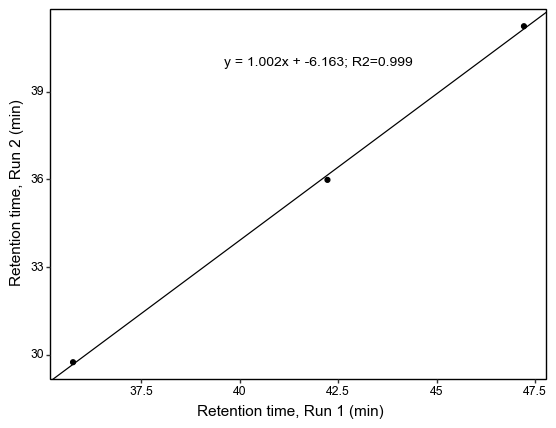

<ggplot: (379652791)>

In [14]:
norm_plot = (ggplot(norm_table, aes(x='Run 1',y='Run 2'))
            + geom_point()
            + geom_abline(slope=slope, intercept=yint)
            + annotate('text', x=42, y=40, label=f'y = {round(slope,3)}x + {round(yint,3)}; R2={round(rsquared,3)}', size=10, family='Arial')
            + theme_bw()
            + theme(text=element_text(colour='black', family='Arial'),
                    panel_grid=element_blank(),
                    panel_border=element_rect(colour='black'))
            + xlab('Retention time, Run 1 (min)')
            + ylab('Retention time, Run 2 (min)')
            )
norm_plot

In [15]:
norm_plot.save('run-time-normalization-regression.pdf', width=70, height=70, units='mm', verbose=False)

In [16]:
norm_table_for_labels = norm_table.rename(columns={'Run 1':'Cfx. aurantiacus (2022.1)', 'Run 2':'Cfx. aurantiacus (2023.7)'})
norm_table_for_labels['Cfx. aurantiacus (2023.7)'] = norm_table_for_labels['Cfx. aurantiacus (2023.7)'] - yint

norm_table_for_labels = norm_table_for_labels\
  .melt(id_vars='peak_num', value_vars=['Cfx. aurantiacus (2022.1)','Cfx. aurantiacus (2023.7)'], 
        var_name='Sample', value_name='Retention time (min)')

norm_table_for_labels['Retention time Run 2 (min)'] = norm_table_for_labels['Retention time (min)'] + yint

profile_order = pd.DataFrame({'Sample':['Cfx. aurantiacus (2022.1)','Cfx. aurantiacus (2023.7)'], 'Position':[1,2]})

norm_table_for_labels = norm_table_for_labels.drop(columns='peak_num')\
  .merge(profile_order, on='Sample', how='left')

norm_table_for_labels['Absorbance (A.U.)'] = norm_table_for_labels['Position'] * 350000

norm_table_for_labels

,Sample,Retention time (min),Retention time Run 2 (min),Position,Absorbance (A.U.)
0,Cfx. aurantiacus (2022.1),35.765000,29.602194,1,350000
1,Cfx. aurantiacus (2022.1),42.229000,36.066194,1,350000
2,Cfx. aurantiacus (2022.1),47.221000,41.058194,1,350000
3,Cfx. aurantiacus (2023.7),35.901806,29.739000,2,700000
4,Cfx. aurantiacus (2023.7),42.141806,35.979000,2,700000
5,Cfx. aurantiacus (2023.7),47.399806,41.237000,2,700000


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


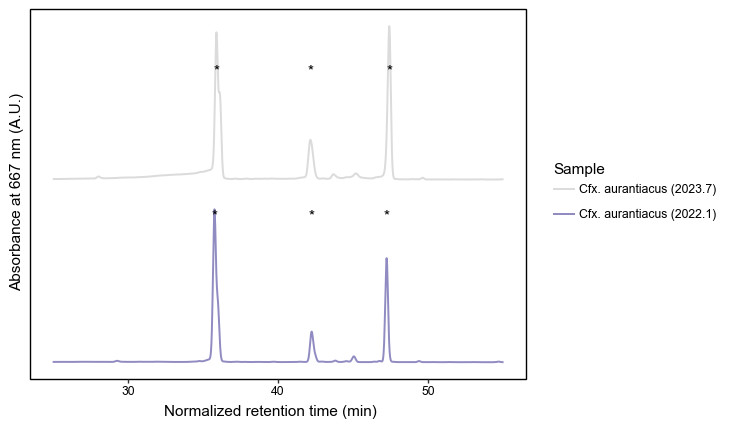

<ggplot: (371104544)>

In [17]:
# Normalize the re-run Cfx. aurantiacus sample to compare side-by-side with the original sample
caur2_time_norm = caur2_raw[['Retention time (min)', '667']].rename(columns={'667': 'Cfx. aurantiacus (2023.7)'})
caur2_time_norm['Retention time (min)'] = caur2_time_norm['Retention time (min)'] - yint

hplc_profiles_merged = caur_raw[['Retention time (min)', '667']].rename(columns={'667': 'Cfx. aurantiacus (2022.1)'})\
  .merge(caur2_time_norm, on='Retention time (min)', how='outer')
hplc_profiles_merged = hplc_profiles_merged[(hplc_profiles_merged['Retention time (min)'] > 25) & (hplc_profiles_merged['Retention time (min)'] < 55)]

# Normalize absorbances based on max peak height
max1 = hplc_profiles_merged['Cfx. aurantiacus (2022.1)'].max()
max2 = hplc_profiles_merged['Cfx. aurantiacus (2023.7)'].max()
hplc_profiles_merged['Cfx. aurantiacus (2023.7)'] = hplc_profiles_merged['Cfx. aurantiacus (2023.7)'] * max1 / max2

# Offset profiles on plot
offset = max1 * 1.2
hplc_profiles_merged['Cfx. aurantiacus (2023.7)'] = hplc_profiles_merged['Cfx. aurantiacus (2023.7)'] + offset

hplc_profiles_merged = hplc_profiles_merged.melt(id_vars='Retention time (min)', var_name='Sample', value_name='Absorbance (A.U.)')
hplc_profiles_merged['Retention time Run 2 (min)'] = hplc_profiles_merged['Retention time (min)'] + yint

hplc_profiles_merged['Sample'] = pd.Categorical(hplc_profiles_merged['Sample'], 
                                                categories=['Cfx. aurantiacus (2023.7)', 'Cfx. aurantiacus (2022.1)'], 
                                                ordered=True)

profile_plot = (ggplot(hplc_profiles_merged, aes(x='Retention time (min)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + geom_text(data=norm_table_for_labels, label='*')
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#d2d2d2', '#7570b3'])
              + ylab('Absorbance at 667 nm (A.U.)')
              + xlab('Normalized retention time (min)')
              )

profile_plot

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


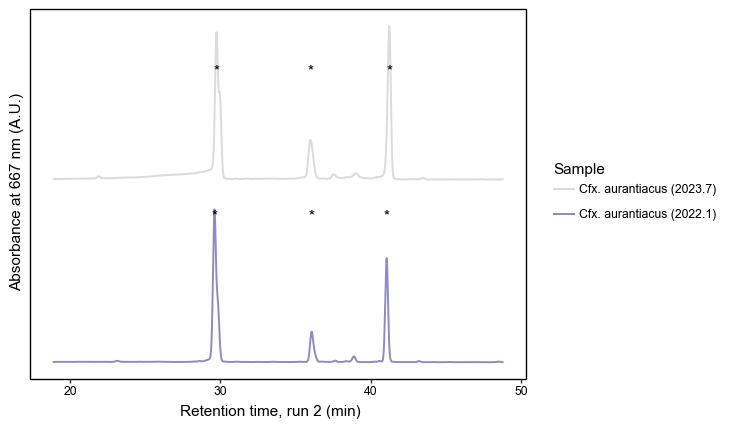

<ggplot: (385259083)>

In [18]:
# This second plot is the same as the one above but has a different x-axis showing the pre-normalized run 2 time.
profile_plot_run2 = (ggplot(hplc_profiles_merged, aes(x='Retention time Run 2 (min)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + geom_text(data=norm_table_for_labels, label='*')
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#d2d2d2', '#7570b3'])
              + ylab('Absorbance at 667 nm (A.U.)')
              + xlab('Retention time, run 2 (min)')
              )

profile_plot_run2

In [19]:
profile_plot.save('run-time-normalization-results-run1.pdf', width=70, height=70, units='mm', verbose=False)
profile_plot_run2.save('run-time-normalization-results-run2.pdf', width=70, height=70, units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [20]:
# Normalize the R. caps sample
rcaps_time_norm = rcaps_raw[['Retention time (min)', '770']].rename(columns={'770': 'R. capsulatus'})
rcaps_time_norm['Retention time (min)'] = rcaps_time_norm['Retention time (min)'] - yint
rcaps_time_norm.head()

,Retention time (min),R. capsulatus
0,6.162806,0
1,6.173806,0
2,6.183806,0
3,6.194806,0
4,6.205806,0


In [21]:
# Get the retention times and spectra of peaks within 30 seconds of the Bchl a standard
rcaps_bchla_peak = rcaps_processed.tables.peaks.sort_values(by='770', ascending=False, ignore_index=True)\
  ['Retention time (min)'][0]

rcaps_bchla_spectrum = tabulate_spectra(rcaps_processed.tables.profile, pd.Series(rcaps_bchla_peak), round_digits=None)

rcaps_bchla_peak_adj = rcaps_bchla_peak - yint
print(f'Normalized retention time (min) of R. caps. sample: {rcaps_bchla_peak_adj.round(1)}')

print('Cfx. aurantiacus:')
caur_bchla_spectrum = get_spectrum_of_peak_in_range(caur_processed, 
                                                    (rcaps_bchla_peak_adj-0.5, 
                                                     rcaps_bchla_peak_adj+0.5))
print('Chl. ferrooxidans:')
cferro_bchla_spectrum = get_spectrum_of_peak_in_range(cferro_processed, 
                                                    (rcaps_bchla_peak_adj-0.5, 
                                                     rcaps_bchla_peak_adj+0.5))
print('Ca. Chx. allophototropha:')
chx_bchla_spectrum = get_spectrum_of_peak_in_range(chx_processed, 
                                                    (rcaps_bchla_peak_adj-0.5, 
                                                     rcaps_bchla_peak_adj+0.5))

Normalized retention time (min) of R. caps. sample: 44.1
Cfx. aurantiacus:
Peak found at 43.82 min.
Chl. ferrooxidans:
Peak found at 44.02 min.
Ca. Chx. allophototropha:
Peak found at 43.9 min.


In [22]:
# Plot the HPLC profiles
hplc_profiles_merged = caur_raw[['Retention time (min)', '770']].rename(columns={'770': 'Cfx. aurantiacus'})\
  .merge(cferro_raw[['Retention time (min)', '770']].rename(columns={'770': 'Chl. ferrooxidans'}), on='Retention time (min)', how='inner')\
  .merge(chx_raw[['Retention time (min)', '770']].rename(columns={'770': 'Ca. Chx. allophototropha'}), on='Retention time (min)', how='inner')\
  .merge(rcaps_time_norm, on='Retention time (min)', how='outer')
hplc_profiles_merged = hplc_profiles_merged[(hplc_profiles_merged['Retention time (min)'] > 25) & (hplc_profiles_merged['Retention time (min)'] < 55)]

# Normalize based on max peak height
max1 = hplc_profiles_merged['Cfx. aurantiacus'].max()
max2 = hplc_profiles_merged['Chl. ferrooxidans'].max()
max3 = hplc_profiles_merged['Ca. Chx. allophototropha'].max()
max4 = hplc_profiles_merged['R. capsulatus'].max()
hplc_profiles_merged['Cfx. aurantiacus'] = hplc_profiles_merged['Cfx. aurantiacus'] * max4 / max1
hplc_profiles_merged['Chl. ferrooxidans'] = hplc_profiles_merged['Chl. ferrooxidans'] * max4 / max2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] * max4 / max3

# Offset
offset = max4 * 1.1
hplc_profiles_merged['R. capsulatus'] = hplc_profiles_merged['R. capsulatus'] + offset * 3
hplc_profiles_merged['Cfx. aurantiacus'] = hplc_profiles_merged['Cfx. aurantiacus'] + offset * 2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] + offset

hplc_profiles_merged = hplc_profiles_merged.melt(id_vars='Retention time (min)', var_name='Sample', value_name='Absorbance (A.U.)')

hplc_profiles_merged['Sample'] = pd.Categorical(hplc_profiles_merged['Sample'], 
                                                categories=['R. capsulatus', 'Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans'], ordered=True)

hplc_profiles_merged.head()

,Retention time (min),Sample,Absorbance (A.U.)
0,25.003,Cfx. aurantiacus,407786.742107
1,25.013,Cfx. aurantiacus,407899.969749
2,25.024,Cfx. aurantiacus,407917.389387
3,25.035,Cfx. aurantiacus,408056.746485
4,25.045,Cfx. aurantiacus,407995.777755


In [23]:
# Add asterisks onto identified HPLC peaks
sample_names = ['R. capsulatus', 'Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans']
bchla_peak_times = [rcaps_bchla_peak_adj, 
                    caur_bchla_spectrum['Retention time (min)'][0],
                    chx_bchla_spectrum['Retention time (min)'][0], 
                    cferro_bchla_spectrum['Retention time (min)'][0]]
plot_order_rev = [4,3,2,1]

bchla_peak_time_summary = pd.DataFrame({'Sample': sample_names, 'Retention time (min)': bchla_peak_times,
                                       'Absorbance (A.U.)': plot_order_rev})

bchla_peak_time_summary['Absorbance (A.U.)'] = bchla_peak_time_summary['Absorbance (A.U.)'] * 180000

bchla_peak_time_summary

,Sample,Retention time (min),Absorbance (A.U.)
0,R. capsulatus,44.103806,720000
1,Cfx. aurantiacus,43.819000,540000
2,Ca. Chx. allophototropha,43.904000,360000
3,Chl. ferrooxidans,44.021000,180000


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


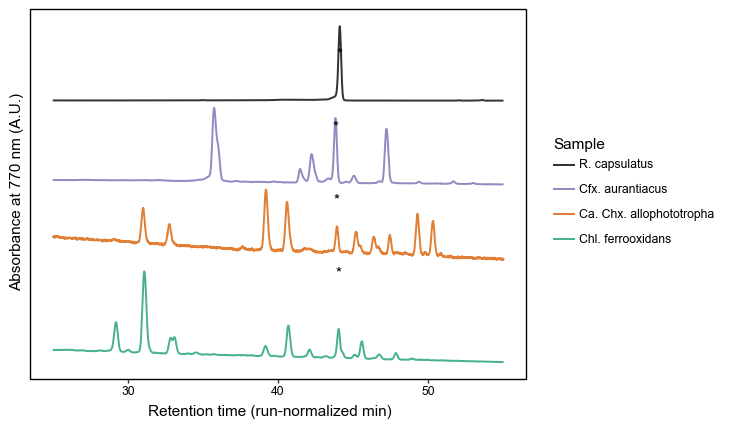

<ggplot: (385320916)>

In [24]:
profile_plot = (ggplot(hplc_profiles_merged, aes(x='Retention time (min)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + geom_text(data=bchla_peak_time_summary, label='*')
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#000000', '#7570b3', '#d95f02', '#1b9e77'])
              + ylab('Absorbance at 770 nm (A.U.)')
              + xlab('Retention time (run-normalized min)')
              )

profile_plot

In [25]:
profile_plot.save('HPLC_profiles_770nm.pdf', width=70, height=80, units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [26]:
# Plot the Bchl a spectra
max_spectra = caur_bchla_spectrum.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Cfx. aurantiacus'})\
  .merge(cferro_bchla_spectrum.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Chl. ferrooxidans'}), on='Wavelength (nm)', how='inner')\
  .merge(chx_bchla_spectrum.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Ca. Chx. allophototropha'}), on='Wavelength (nm)', how='inner')\
  .merge(rcaps_bchla_spectrum.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'R. capsulatus'}), on='Wavelength (nm)', how='inner')

# Normalize based on max peak height
max1 = max_spectra['Cfx. aurantiacus'].max()
max2 = max_spectra['Chl. ferrooxidans'].max()
max3 = max_spectra['Ca. Chx. allophototropha'].max()
max4 = max_spectra['R. capsulatus'].max()
max_spectra['Cfx. aurantiacus'] = max_spectra['Cfx. aurantiacus'] * max4 / max1
max_spectra['Chl. ferrooxidans'] = max_spectra['Chl. ferrooxidans'] * max4 / max2
max_spectra['Ca. Chx. allophototropha'] = max_spectra['Ca. Chx. allophototropha'] * max4 / max3

# Offset
offset = max4 * 0.9
max_spectra['R. capsulatus'] = max_spectra['R. capsulatus'] + offset * 3
max_spectra['Cfx. aurantiacus'] = max_spectra['Cfx. aurantiacus'] + offset * 2
max_spectra['Ca. Chx. allophototropha'] = max_spectra['Ca. Chx. allophototropha'] + offset

max_spectra = max_spectra.melt(id_vars='Wavelength (nm)', var_name='Sample', value_name='Absorbance (A.U.)')
max_spectra['Sample'] = pd.Categorical(max_spectra['Sample'], categories=['R. capsulatus', 'Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans'], ordered=True)

max_spectra.head()

,Wavelength (nm),Sample,Absorbance (A.U.)
0,350,Cfx. aurantiacus,511590.448744
1,351,Cfx. aurantiacus,513310.172659
2,352,Cfx. aurantiacus,515328.978994
3,353,Cfx. aurantiacus,517746.561888
4,354,Cfx. aurantiacus,519840.138828


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


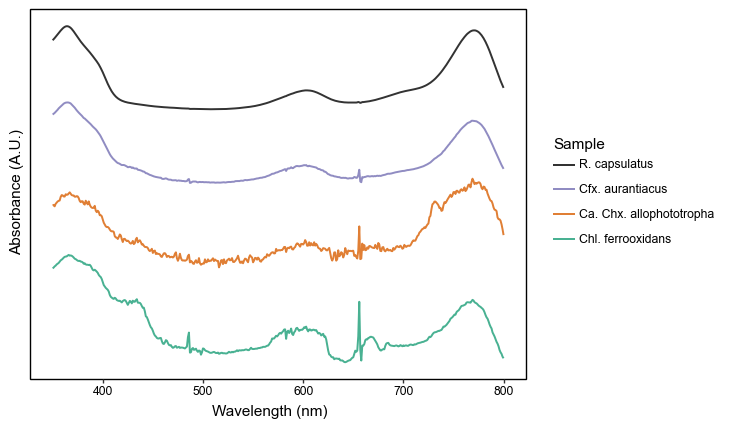

<ggplot: (385685370)>

In [27]:
spectra_plot = (ggplot(max_spectra, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#000000', '#7570b3', '#d95f02', '#1b9e77'])
              )

spectra_plot

In [28]:
spectra_plot.save('HPLC_spectra_770nm.pdf', width=70, height=80, units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [29]:
# Summarize the peaks in the Bchl a spectra (can add these wavelength labels manually to the spectra_plot later)
bchla_spectra_peaks_summary = tabulate_peaks(caur_bchla_spectrum, 'Absorbance (A.U.)', 'Wavelength (nm)', 1000)
bchla_spectra_peaks_summary.insert(0, 'Sample', 'Cfx. aurantiacus')
bchla_spectra_peaks_summary

tmp_peaks = tabulate_peaks(cferro_bchla_spectrum, 'Absorbance (A.U.)', 'Wavelength (nm)', 1000)
tmp_peaks.insert(0, 'Sample', 'Chl. ferrooxidans')
bchla_spectra_peaks_summary = pd.concat([bchla_spectra_peaks_summary, tmp_peaks], axis=0)

tmp_peaks = tabulate_peaks(chx_bchla_spectrum, 'Absorbance (A.U.)', 'Wavelength (nm)', 200)
tmp_peaks.insert(0, 'Sample', 'Ca. Chx. allophototropha')
bchla_spectra_peaks_summary = pd.concat([bchla_spectra_peaks_summary, tmp_peaks], axis=0)

tmp_peaks = tabulate_peaks(rcaps_bchla_spectrum, 'Absorbance (A.U.)', 'Wavelength (nm)', 1000)
tmp_peaks.insert(0, 'Sample', 'R. capsulatus')
bchla_spectra_peaks_summary = pd.concat([bchla_spectra_peaks_summary, tmp_peaks], axis=0)

bchla_spectra_peaks_summary

,Sample,Wavelength (nm),Absorbance (A.U.)
15,Cfx. aurantiacus,365,23174
253,Cfx. aurantiacus,603,6042
306,Cfx. aurantiacus,656,4767
419,Cfx. aurantiacus,769,18175
16,Chl. ferrooxidans,366,8691
136,Chl. ferrooxidans,486,726
253,Chl. ferrooxidans,603,1337
306,Chl. ferrooxidans,656,3884
318,Chl. ferrooxidans,668,292
419,Chl. ferrooxidans,769,4083
